In [56]:
import pandas as pd
import re
#import demoji  # Modul für Emoji-Entfernung
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as en_stopwords
from spacy.lang.de.stop_words import STOP_WORDS as de_stopwords
# Step 1: Load and Clean the data

# Load the data
reddit_data = pd.read_csv("reddit_data.csv")

# Filter rows where "Lina E" doesn't occur in title, body or comments (case insensitive)
reddit_data = reddit_data[reddit_data.apply(lambda row: 'lina e' in str(row['title']).lower() + 
                                                      str(row['body']).lower() + 
                                                      str(row['comments']).lower(), axis=1)]

# Define the necessary helper functions again

# Function to clean text
def clean_text_v2(text):
    # Remove links
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'\n\n+', ' ', text)
    text = text.replace('\n', ' ')  # Zeilenumbrüche durch Leerzeichen ersetzen
    # Remove Emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

# Function to extract comments
def extract_comments(comments_str):
    # Removing square brackets and quotes
    comments_list = comments_str.strip('][').split("', '")
    return comments_list

# Apply cleaning and construct the documents list again

# Clean the text
reddit_data['title'] = reddit_data['title'].apply(clean_text_v2)
reddit_data['body'] = reddit_data['body'].apply(clean_text_v2)
reddit_data['comments'] = reddit_data['comments'].apply(clean_text_v2)

# Construct the documents list
documents = []
for index, row in reddit_data.iterrows():
    title_body = row['title']
    if not pd.isna(row['body']) and row['body'] != 'nan':
        title_body += " " + row['body']
    documents.append(title_body)

    # Split comments and add each comment as a separate document
    comments = extract_comments(row['comments'])
    documents.extend(comments)

custom_stopwords = {"deleted", "reddit", "mal", "removed","ll", "ve", "halt", "sub"}  # Fügen Sie hier Ihre Stoppwörter hinzu
all_stopwords = list(en_stopwords.union(de_stopwords).union(custom_stopwords))

# Einträge, die Sie entfernen möchten
words_to_remove = ["tag", "rechte", "rechter"]

# Entfernen Sie die Einträge aus der Stopwort-Liste
filtered_stopwords = [word for word in all_stopwords if word not in words_to_remove]

def simple_preprocess_v2(doc):
    # Convert to lowercase and remove punctuation
    doc = ''.join(ch for ch in doc if ch not in set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')).lower()
    
    # Stopword removal
    tokens = doc.split()
    tokens = [token for token in tokens if token not in filtered_stopwords]
    
    return ' '.join(tokens)
# Step 3: Preprocess the documents


simple_preprocessed_documents_v2 = [simple_preprocess_v2(doc) for doc in documents]

# Check the length of the documents list
len(documents)


4928

In [57]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 10

# Create a count vectorizer to transform the preprocessed documents into a term-document matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
X = vectorizer.fit_transform(simple_preprocessed_documents_v2)

# Apply LDA
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, random_state=42)
lda.fit(X)

def display_topics(model, feature_names, n_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]])
        topics.append(f"Topic {topic_idx + 1}: {top_words}")
    return topics

# Get the top words for each topic
topics = display_topics(lda, vectorizer.get_feature_names_out())

topics

['Topic 1: einfach gewalt leute meinung eher frage sehen klar problem glaube',
 'Topic 2: artikel eigentlich fall gewalt einfach polizei 129 irgendwas sagen wissen',
 'Topic 3: genau demokratie bekommen leute tatsächlich sozialismus weg funktioniert weiß argument',
 'Topic 4: que de não arthur se pra com eu os lina',
 'Topic 5: staat gruppe lina gewalt linke nazis ukraine rechte selbstjustiz linken',
 'Topic 6: lina prozess urteil leipzig verurteilt fall hab dresden haft gefunden',
 'Topic 7: nazis menschen gewalt rechte leute linksextremismus linke egal nazi einfach',
 'Topic 8: links ne deutschland faschismus afd rechts linke nazis gewalt partei',
 'Topic 9: polizei straftaten vereinigung polizisten linken indizien kriminellen fall soko beweise',
 'Topic 10: lina opfer neonazis nazis mütze strafe mord kopf gericht uhaft']

In [45]:
# Pfad zur Ausgabedatei
output_file_path = "preprocessed_documents.txt"

# Vorverarbeitete Dokumente in die Datei schreiben
with open(output_file_path, "w", encoding="utf-8") as output_file:
    for doc in simple_preprocessed_documents_v2:
        output_file.write(doc + "\n")

In [46]:
print(all_stopwords)

['welches', 'zuerst', 'jeden', 'every', 'allem', 'these', 'achtes', 'gutes', 'itself', 'becomes', 'out', 'yourselves', 'niemand', 'dasein', 'front', 'hin', 'offen', 'however', 'siebter', 'euch', 'cannot', 'beim', 'weit', 'zehnte', 'zweites', 'below', 'thereupon', 'where', 'move', 'niemandem', 'neunte', 'on', 'jemandem', 'after', 'along', 'former', 'früher', 'keinem', 'sowie', 'nine', '’ve', 'third', 'endlich', 'weniges', 'noone', 'zusammen', 'tagen', 'doing', 'gemusst', 'wollte', 'möglich', 'fünftes', 'bei', 'everywhere', 'dein', 'beiden', "'s", 'bekannt', 'he', 'have', 'rechtes', 'fünf', 'ins', 'zwanzig', 'achten', 'etwas', 'kein', 'if', 'but', 'jenem', 'großer', 'seid', 'whereas', 'besten', 'tag', 'schon', "'ve", 'erster', '‘ve', 'weil', 'does', 'thereby', 'da', 'auf', 'aus', 'will', 'anyhow', 'siebentes', 'siebten', 'vierten', 'je', 'ag', 'jener', 'a', 'sechs', 'jemanden', 'ein', 'zwischen', 'herself', 'being', 'aller', 'darauf', 'more', 'einige', 'any', 'fifteen', 'durften', 'until

In [58]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from spacy.lang.en.stop_words import STOP_WORDS as en_stopwords
from spacy.lang.de.stop_words import STOP_WORDS as de_stopwords

# Daten laden
reddit_data = pd.read_csv("reddit_data.csv")

# Ihre angepasste Liste von Stoppwörtern
custom_stopwords = {"deleted", "reddit", "mal", "removed","ll", "ve", "halt"}  # Fügen Sie hier Ihre Stoppwörter hinzu
all_stopwords = list(en_stopwords.union(de_stopwords).union(custom_stopwords))

# Erstellen Sie einen CountVectorizer, der auch Bi- und Trigramme berücksichtigt
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=filtered_stopwords, max_df=0.95, min_df=2, max_features=1000)

# Umwandeln der Dokumente in eine Term-Dokument-Matrix
X = vectorizer.fit_transform(simple_preprocessed_documents_v2)

# Anwenden von LDA
lda = LatentDirichletAllocation(n_components=10, max_iter=10, random_state=42)
lda.fit(X)

# Funktion, um die Top-Wörter für jedes Thema anzuzeigen
def display_topics(model, feature_names, n_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]])
        topics.append(f"Topic {topic_idx + 1}: {top_words}")
    return topics

# Top-Wörter für jedes Thema anzeigen
topics = display_topics(lda, vectorizer.get_feature_names_out())
topics


['Topic 1: einfach polizei meinung deutschland links mütze faschismus leute grund finde',
 'Topic 2: artikel mord strafe gilt körperverletzung gericht quelle verurteilt linken kommentare',
 'Topic 3: polizei gewalt polizisten einfach linke demos linken demo leute straftaten',
 'Topic 4: gewalt problem nazi staat menschen linksextremismus linke politische gefahr extremismus',
 'Topic 5: links rechts gewalt menschen rechte linken staat selbstjustiz nazis hab',
 'Topic 6: uhaft leipzig völlig demo leute lina ne vereinigung stadt tag',
 'Topic 7: lina gruppe prozess vereinigung fall urteil kriminelle gericht szene taten',
 'Topic 8: que de não arthur se com pra eu ik lina',
 'Topic 9: polizei soko straftaten urteil danke sagen sachsen paar person nsu',
 'Topic 10: nazis ukraine menschen leute russland krieg nazi einfach falsch staat']

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Dokumente in Themen zuordnen
document_topics = lda.transform(X)

# Finden Sie für jedes Thema das passendste Dokument
for topic_idx in range(10):
    most_related_doc_idx = document_topics[:, topic_idx].argmax()
    most_related_doc = simple_preprocessed_documents_v2[most_related_doc_idx]
    print(f"Topic {topic_idx}: Most relevant document: {most_related_doc}")


Topic 0: Most relevant document: bundesrepublik wesentlich stärkere staatliche strukturen weimarer republiknnauf papier vermutlich tatsächlich stärker hoffentlich zeigen müssennn bevölkerung bundesrepublik verfügt gegensatz weimarer republik demokratische tradition obrigkeitsstaat sozialisiertnnich weiß historisches argument wert ansehe wiege modernen demokratie vereinigten staaten gehtnngenerell finde zielführend tradition argumentieren geschichtliche staatsumwälzungen franzosen 800 tradition monarchen revolution trotzdemnn afd gegensatz nsdap führerprinzip strukturiert kriegt pläne machtübernahme formulierennndie afd bewusst wahrgenommen scheut allzu starke vergleichsmomente liefern schwäche wahrnehmen kriegen einzige interpretation eher vermuten stärke finden nützliche idioten eigentlich partei positionen legitimierennn verfassungsmäßige ordnung struktur unseres föderalismus schließen weimar 20 ausnnich niemals weimar 20 erwarten berlin 10nndarüber hinaus klarmachen umstände machtüb

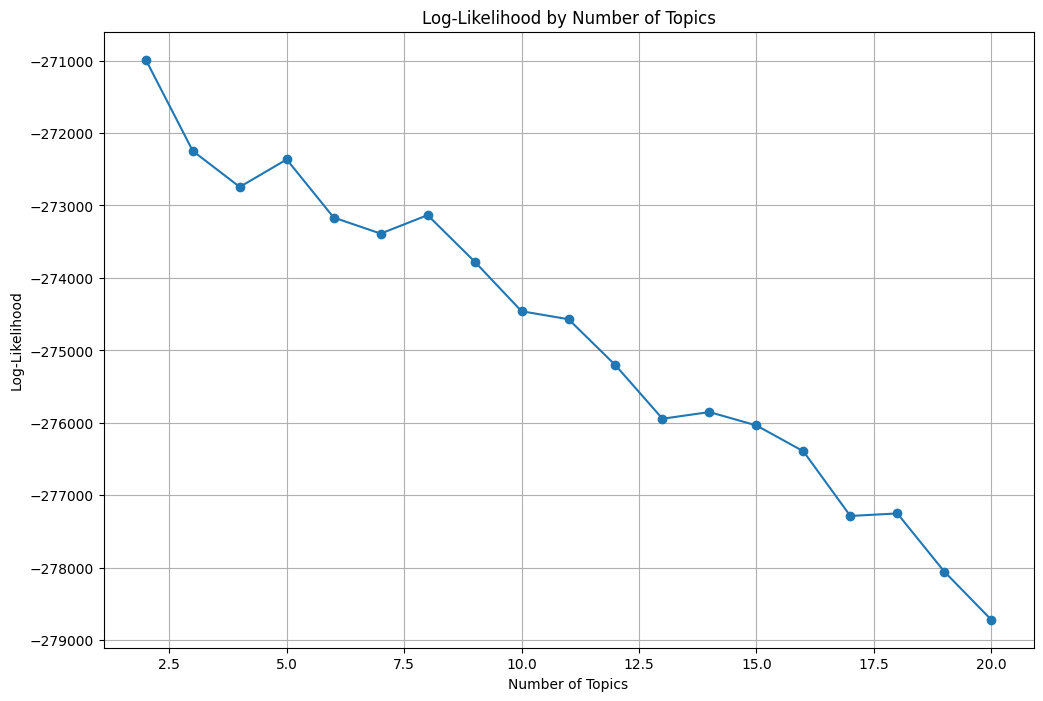

In [59]:
# Bestimmen der besten Anzahl von Topics
log_likelihoods = []
possible_n_topics = range(2, 21)  # z.B. von 2 bis 20 Topics

for n in possible_n_topics:
    lda_model = LatentDirichletAllocation(n_components=n, max_iter=10, random_state=42)
    lda_model.fit(X)
    log_likelihoods.append(lda_model.score(X))

# Plot der Log-Likelihood-Werte
plt.figure(figsize=(12, 8))
plt.plot(possible_n_topics, log_likelihoods, marker='o')
plt.title("Log-Likelihood by Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()




In [33]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
# Visualisierung der Topics (angenommen, die beste Anzahl von Topics ist z.B. 10)
best_n_topics = 5  # Dies sollte basierend auf dem obigen Plot angepasst werden
lda_best = LatentDirichletAllocation(n_components=best_n_topics, max_iter=10, random_state=42)
lda_best.fit(X)
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_best, X, vectorizer)

# Bestimmung der besten Dokumente für jedes Topic
topic_assignments = lda_best.transform(X)
best_document_indices = topic_assignments.argmax(axis=0)
best_documents = [simple_preprocessed_documents_v2[i] for i in best_document_indices]

for idx, doc in enumerate(best_documents, 1):
    print(f"Bestes Dokument für Topic {idx}:\n{doc}\n")

# Güte der Topics
print("Log-Likelihood des besten Modells:", lda_best.score(X))
print("Perplexität des besten Modells:", lda_best.perplexity(X))

ModuleNotFoundError: No module named 'pyLDAvis.sklearn'